# Intent Clustering, Document Embeddings, and Unsupervised Learning

In this notebook, I take the preprocessed and tokenized data in the previous notebook and try to assign labels for each Tweet in the dataset by using meaningful document embedding methods (so my models can read the data) and unsupervised learning methods such as K-Means, DBScan, and LDA.

In [86]:
# We need more packages!
# Data science
import pandas as pd
print(f"Pandas: {pd.__version__}")
import numpy as np
print(f"Numpy: {np.__version__}")

# Unsupervised Learning
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from zeugma.embeddings import EmbeddingTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.metrics import silhouette_score, silhouette_samples

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

# Word Embeddings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
print(f'gensim: {gensim.__version__}')

# Doc2Vec
from nltk.tokenize import word_tokenize 
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

# Storing as objects via serialization
from tempfile import mkdtemp
import pickle
import joblib

# Cool progress bars
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()  # Enable tracking of execution progress

Pandas: 1.0.5
Numpy: 1.18.5
gensim: 3.8.0


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Previewing the current data we are working with

In [11]:
!ls objects

labels_grand.pkl      wcss-kmeans.pkl
processed_inbound.pkl wcss_grand.pkl


In [12]:
# Loading in the already saved processed dataset
processed_inbound = pd.read_pickle('objects/processed_inbound.pkl')

In [13]:
# We start with this data, here's the preview
processed_inbound.head()

0     [new, update, ️, make, sure, download, yesterday]
2         [try, reset, setting, .., restart, phone, ..]
6     [hey, anyone, else, upgraded, io, 11.1, issue,...
10               [hello, line, close, tonight, #, help]
12    [hello, internet, someone, explain, symbol, ke...
Name: inbound_text, dtype: object

Here I scale and transform my data. Algorithms such as K-Means is distance based, so it's still relevant to scale.

# Embedding and Vectorizing in a Meaningful Way

It is incredibly important to be able to represent this text data as in a meaningful way as to have similar Tweets have closer distances than different Tweets that have different intents. However, since I am working with sequences, I could not just embed their individual words because that will result in a different dimensionality for every single Tweet, and this is something that unsupervised learning algorithms do not know how to handle.

Some of these document embedding methods are:
* BERT
* FastText
* Doc2Vec
* Word2Vec (NN architecture)
* Skipthought
* gloVe (word embedding)

With these, you'll get some kind of file with those words and you'll basically generate this word-to-word embedding matrix and you pass it in as the weights layer in your Neural Network..

Someone has run this on a massive data and released the embeddings the model learned on the internet. They different contexts with learning. It might have been trained with the words from like academic papers, and the meaning of the word it learns is might be different than general twitter data, which is why I explore many methods and try to find what they are trained on.

Gensim, which is one of the package I use, constrains pretrained word embeddings  and  have a special data format where you can basically load it in as a numpy array.

### 1. Count Vectorization

The easiest way to represent a document as a vector is with a bagofwords CountVectorizer. This will turn each document to be a 1D array, which I think is a good starting point for putting into my clustering algorithms. Let's see how it does. 

The count vectorizer only accepts the Series if the document is represented as a String, not a tokenized list. So I do that change here:

In [22]:
# Representing my tokenized data as String documents and storing it into a variable
string_processed_inbound = processed_inbound.progress_apply(" ".join)

I set the min_df paramater to 5 to only include terms that occur more than 5 times in my Count Vectorized data.

In [23]:
string_processed_inbound.head()

0             new update ️ make sure download yesterday
2                 try reset setting .. restart phone ..
6     hey anyone else upgraded io 11.1 issue capital...
10                      hello line close tonight # help
12    hello internet someone explain symbol keep app...
Name: inbound_text, dtype: object

This string form also represents each row as a document. That's ultimately what I need to do for my clustering to be effective, because each point needs to represent one sequence altogether, not vectorized individual words.

In [24]:
# Vectorizing the data with Count Vectorizer
bagofwords = CountVectorizer(min_df = 5).fit(string_processed_inbound)
inbound_cv = bagofwords.transform(string_processed_inbound)
inbound_cv # Output will be a sparse matrix

<78592x5152 sparse matrix of type '<class 'numpy.int64'>'
	with 801170 stored elements in Compressed Sparse Row format>

Before we move on, let's visualize and do what we did earlier and view the top 10 most frequent words in my processed data.

This tells me most of the customer queries are about phones, particularly iOS and battery fixes. We also see thanks rank quite high, which is a good thing because it might indicate gratitude (which indicates a closing intent for my chatbot). Hi (rank 44) and hey (rank 25) classifies a greeting intent, and it's good to see that they appear a lot of times. Things are looking promising right now, but we wouldn't be able to see the quality until we actually start clustering.

### 2.TFIDF

In [30]:
tfidf = TfidfVectorizer(min_df=5, ngram_range = (1,3))
# Storing tfidf data and transforming them into sparse matrices
inbound_tfidf = tfidf.fit_transform(string_processed_inbound)

In [32]:
inbound_tfidf

<78592x35232 sparse matrix of type '<class 'numpy.float64'>'
	with 1324907 stored elements in Compressed Sparse Row format>

## Pretrained word embeddings

Bag of words lose many of the subtleties such as word ordering. This is why I will try these other text vectorization methods. These days we have more effective methods, especially since what I want to encode in these vectors are intent clusters.

### 3. GloVe
I am going to use multiple word embeddings to vectorize my text in different ways, and then test which one is the best word embedding to use, starting with the Glove word embedding. GloVe is an unsupervised learning algorithm for getting vector representations for words.

DISCLAIMER: I won't be using this one because my clustering algorithms only work when each tweet is one point, and this is a word transformer. I am leaving this part in my notebook as a progress log.

Useful sources for this step: 
* [Guide to word to vec word embeddings](https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92)
* Zeugma Docs
    * https://pypi.org/project/zeugma/0.41/
    * https://github.com/nkthiebaut/zeugma

In [33]:
glove = EmbeddingTransformer('glove')

In [35]:
# Applying it to the entire training data
inbound_glove = string_processed_inbound.progress_apply(glove.transform)

As we can see, gloVe transforms individual sentences as multiple word vectors. We need an algorithm that transforms the entire sentence to one vector, so that it represents one point in space.

In [40]:
inbound_glove.iloc[0].shape

(41, 25)

In [43]:
inbound_glove.iloc[1].shape

(37, 25)

It's interesting, though, to play with this around conceptually even if we won't use it. We can check the cosine similarity between the first and second sentence should give you similarities across words in the sequence, which is interesting because it works when they are of different length.

In [44]:
similarity = cosine_similarity(inbound_glove.iloc[0], inbound_glove.iloc[1])
similarity

array([[0.7225855 , 0.8673227 , 0.40145397, ..., 0.        , 0.744676  ,
        0.744676  ],
       [0.635868  , 0.7468127 , 0.44998685, ..., 0.        , 0.5086868 ,
        0.5086868 ],
       [0.73939735, 0.7719837 , 0.34391314, ..., 0.        , 0.53550535,
        0.53550535],
       ...,
       [0.83396137, 0.8301297 , 0.73543733, ..., 0.        , 0.63138366,
        0.63138366],
       [0.73740643, 0.7176953 , 0.74351704, ..., 0.        , 0.6403916 ,
        0.6403916 ],
       [0.5868363 , 0.53884983, 0.9999997 , ..., 0.        , 0.47835985,
        0.47835985]], dtype=float32)

In [45]:
similarity.shape

(41, 37)

As for intepretation, the cosine similarity could be 0 if the two vectors are perpendicular. And it seems that the similarity matrix takes the shape of the longer matrix that it compares.

### 4. Doc2Vec
This is a way that was developed for word2vec to generalize to paragraphs. Doc2Vec takes the average across them, and each tweet is represented as a single embedding so you have consistent dimensionality.

Word2Vec uses Continuous Bag of Words, which creates a sliding window around each word to predict it from context (surrouding words), and the Skip Gram model. Doc2Vec is based off that.

* https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e
* https://radimrehurek.com/gensim/models/doc2vec.html

In [50]:
data = processed_inbound.iloc[0]
data

['new', 'update', '️', 'make', 'sure', 'download', 'yesterday']

In [53]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]

In [54]:
tagged_data

[TaggedDocument(words=['new'], tags=['0']),
 TaggedDocument(words=['update'], tags=['1']),
 TaggedDocument(words=['️'], tags=['2']),
 TaggedDocument(words=['make'], tags=['3']),
 TaggedDocument(words=['sure'], tags=['4']),
 TaggedDocument(words=['download'], tags=['5']),
 TaggedDocument(words=['yesterday'], tags=['6'])]

Now that the tagging is finished, let's start training our model!

In [55]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size, 
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # Decrease the learning rate
    model.alpha -= 0.0002
    # Fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [56]:
!ls

1. EDA , Wrangling, and Initial Preprocessing.ipynb
2. Intent Clustering, Document Embeddings, and Unsupervised Learning.ipynb
2.1. Meaningful Embeddings and Vectorization.ipynb
3. Intent Classification with Keras.ipynb
4. Natural Language Generation.ipynb
README.md
d2v.model
data
exploratory
images
models
objects


In [57]:
model= Doc2Vec.load("models/d2v.model")
#to find the vector of a document which is not in training data
test_data = word_tokenize("I love chatbots".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)

V1_infer [-1.5038892e-02 -1.6535386e-02 -1.9735284e-02 -1.9328875e-02
 -2.2228742e-02 -7.4572726e-03  1.9306257e-02  8.9250449e-03
  8.2190614e-03  5.7930835e-03 -9.0504149e-03 -5.2679935e-03
 -2.4654318e-02 -1.1019308e-02  4.3625583e-05 -1.8196795e-04
  1.6894562e-02 -2.4621782e-03 -1.6256761e-02 -5.1471563e-03]
[('10', 0.666433572769165), ('2', 0.5544881224632263), ('13', 0.5226146578788757), ('0', 0.4401801824569702), ('12', 0.3988773822784424), ('14', 0.3269912004470825), ('9', 0.3246060311794281), ('4', 0.31271660327911377), ('11', 0.3000207841396332), ('7', 0.29833877086639404)]


In [58]:
# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
model.docvecs['1']

array([ 0.00853298, -0.02657316,  0.02473178, -0.00826399, -0.01995665,
        0.01941   , -0.00422948,  0.02943846, -0.00559517,  0.0094566 ,
       -0.03073188,  0.01469939, -0.0368831 ,  0.013537  ,  0.01832891,
        0.02808696,  0.01232831, -0.02331029, -0.02963574,  0.02320767],
      dtype=float32)

## 5. Skipthoughts Vectorizer

In [ ]:
import skipthoughts
 
class SkipThoughtsVectorizer(object):
    def __init__(self, **kwargs):
        self.model = skipthoughts.load_model()
        self.encoder = skipthoughts.Encoder(self.model)
 
    def fit_transform(self, raw_documents, y):
        return self.encoder.encode(raw_documents, verbose=False)
 
    def fit(self, raw_documents, y=None):
        self.fit_transform(raw_documents, y)
        return self
 
    def transform(self, raw_documents, copy=True):
        return self.fit_transform(raw_documents, None)

# Scaling the Data

Before we cluster, let's make scaled versions of our dataset first, which we definitely would need for distance-based clustering methods.

In [77]:
# This is the data we have so far, they are stored in CSR compressed format
inbound_cv, inbound_tfidf

(<78592x5152 sparse matrix of type '<class 'numpy.int64'>'
 	with 801170 stored elements in Compressed Sparse Row format>,
 <78592x35232 sparse matrix of type '<class 'numpy.float64'>'
 	with 1324907 stored elements in Compressed Sparse Row format>)

I did ```with_mean = False``` because sparse matrices are too big to center before scaling.

In [75]:
# Fitting and transforming to create standard scaled versions of my data
inbound_cv_ss = StandardScaler(with_mean=False).fit_transform(inbound_cv)
inbound_tfidf_ss = StandardScaler(with_mean=False).fit_transform(inbound_cv)

In [78]:
inbound_cv_ss, inbound_tfidf_ss

(<78592x5152 sparse matrix of type '<class 'numpy.float64'>'
 	with 801170 stored elements in Compressed Sparse Row format>,
 <78592x5152 sparse matrix of type '<class 'numpy.float64'>'
 	with 801170 stored elements in Compressed Sparse Row format>)

# Clustering

I am clustering or topic modelling on my data to pull out major themes and manually label these clusters.

I will have more success if my data is all around the same type of domain of customer service, and I was careful to make sure this Twitter Apple data is. That way, my model in the next notebook will capture the nuances of intent classification. Generally, the bot is going to be good at conversing topics on the language it's trained on.

I am aware that with clustering, you can't expect your model to cluster the data the way you want it to be clustered beforehand. It's an algorithm overall. I would wish that they will magically cluster intents together easily, however it might now be that easy! We shall see.

In [ ]:
class Cluster:
    

## 1. K Means
My first approach for the clustering my word vectors is K-Means, which tends to perform well on blobs.

A drawback is that it is very slow, and picking the value for K is hard - I don't even know how many intents there are in the data. This is why I start with larger jumps of K to get a higher level idea of which performs the best, then I dive deeper to finally decide what K works the best for finding the optimal number of intents in my dataset.

In [88]:
# Embedding data
vectorized_data = {'inbound_cv_ss': inbound_cv_ss, 'inbound_tfidf_ss': inbound_tfidf_ss}
# Briefly showing the contents of i and j
for i,j in enumerate(vectorized_data.items()): print(i,j);

0 ('inbound_cv_ss', <78592x5152 sparse matrix of type '<class 'numpy.float64'>'
	with 801170 stored elements in Compressed Sparse Row format>)
1 ('inbound_tfidf_ss', <78592x5152 sparse matrix of type '<class 'numpy.float64'>'
	with 801170 stored elements in Compressed Sparse Row format>)


I am running my entire K-Means on all my data here. And I am doing hyperparamater optimization on n_clusters. The first progress bar is how it's doing with the dataset, the second one is the 

In [90]:
%%time
# My grand dictionaries that will store all my results
wcss_grand = {}
labels_grand = {}
silhouette_scores_grand = {}
n_clusters = [10,20,30,40,50,60,70,80,90,100]

# Iterating through all the differently embedded data
for i,j in tqdm(enumerate(vectorized_data.items())): 
    name = j[0] # Here j[0] is the name of the dataset
    dataset = j[1] # And j[1] is the actual data
    
    # I store my metrics at these following lists
    wcss = []
    labels = []
    silhouette_scores = []
    
    # Looping through values of k
    for k in tqdm(n_clusters):    
        print(f'Currently fitting {name} with {k} clusters... Please wait')
        
        # Initializing with k-means++ ensures that you get don’t fall into the random initialization trap.
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state = 10)
        kmeans.fit(dataset)
        wcss.append(kmeans.inertia_)
        
        # Getting the silhouette score
        labels.append(kmeans.labels_)
        silhouette_scores.append(silhouette_score(dataset, kmeans.labels_))
        
        # Saving the models
        filename = f'models/kmeans/{name}-{k}neighbors.sav'
        joblib.dump(kmeans, filename)
        
    # Updating grand dictionary
    wcss_grand[name + '_wcss'] = wcss
    labels_grand[name + '_labels'] = labels
    silhouette_scores_grand[name + '_silhouettes'] = silhouette_scores
    

/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Currently fitting inbound_cv_ss with 10 clusters... Please wait
Currently fitting inbound_cv_ss with 20 clusters... Please wait
Currently fitting inbound_cv_ss with 30 clusters... Please wait
Currently fitting inbound_cv_ss with 40 clusters... Please wait
Currently fitting inbound_cv_ss with 50 clusters... Please wait
Currently fitting inbound_cv_ss with 60 clusters... Please wait
Currently fitting inbound_cv_ss with 70 clusters... Please wait
Currently fitting inbound_cv_ss with 80 clusters... Please wait
Currently fitting inbound_cv_ss with 90 clusters... Please wait
Currently fitting inbound_cv_ss with 100 clusters... Please wait




KeyError: 'inbound_cv_ss_silhouettes'

[-0.018406604495079408,
 -0.07090591024091716,
 0.08836791766599103,
 -0.06706351411842223,
 -0.06700097725852948,
 -0.14928501551899484,
 -0.06073582042262496,
 -0.1357094575268931,
 -0.13715329823743813,
 -0.13691316897055764]

In [102]:
kmeans_inbound_cv = pd.DataFrame({'n_clusters': n_clusters, 'WCSS': wcss_grand['inbound_cv_ss_wcss'],  'silhouette_scores':silhouette_scores})

In [103]:
kmeans_inbound_cv

,n_clusters,WCSS,silhouette_scores
0,10,4.039656e+08,-0.018407
1,20,4.029887e+08,-0.070906
2,30,4.021257e+08,0.088368
3,40,4.013220e+08,-0.067064
4,50,4.004640e+08,-0.067001
5,60,3.994826e+08,-0.149285
6,70,3.985765e+08,-0.060736
7,80,3.976571e+08,-0.135709
8,90,3.966821e+08,-0.137153
9,100,3.957628e+08,-0.136913


In [104]:
kmeans_inbound_cv.to_csv('kmeans_inbound_cv.csv')

In [107]:
# Final dataframe with labels
pd.DataFrame({'Inbound': })
kmeans.labels_

array([ 3,  3,  3, ..., 11, 19,  3], dtype=int32)

### Storing results

Wow! It took me three hours to apply K-Means over 10 iterations from 10 to 100 for both data types, before scaling. Fortunately, after I scaled it trained much faster. 

I store my results using Python's serialization package called Pickle.

In [196]:
# Dumping my dictionaries that store the results of my k-means iteration

with open('objects/wcss_grand.pkl', 'wb') as handle:
    pickle.dump(wcss_grand, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('objects/labels_grand.pkl', 'wb') as handle:
    pickle.dump(labels_grand, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('objects/labels_grand.pkl', 'wb') as handle:
    pickle.dump(labels_grand, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:
# Storing it into objects I can use in this notebook

with open('objects/wcss-kmeans.pkl', 'rb') as handle:
    wcss_grand = pickle.load(handle)
with open('objects/labels_grand.pkl','rb') as handle:
    labels_grand = pickle.load(handle)

NameError: name 'pickle' is not defined

## Optimizing K-Means

I am making an elbow plot to see if there is a clear elbow, which hopefully I'll find but it's not very likely.

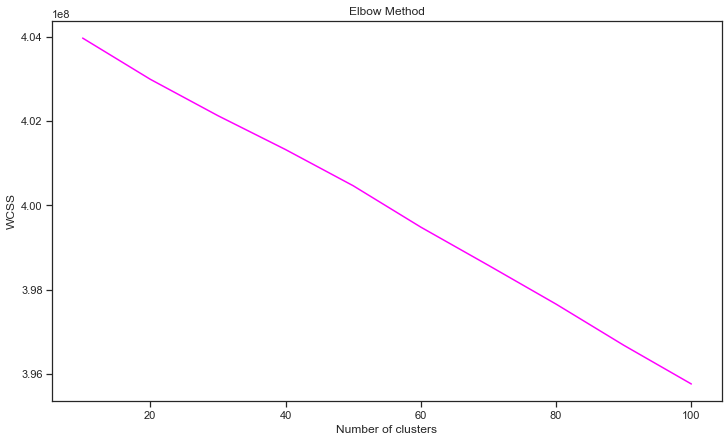

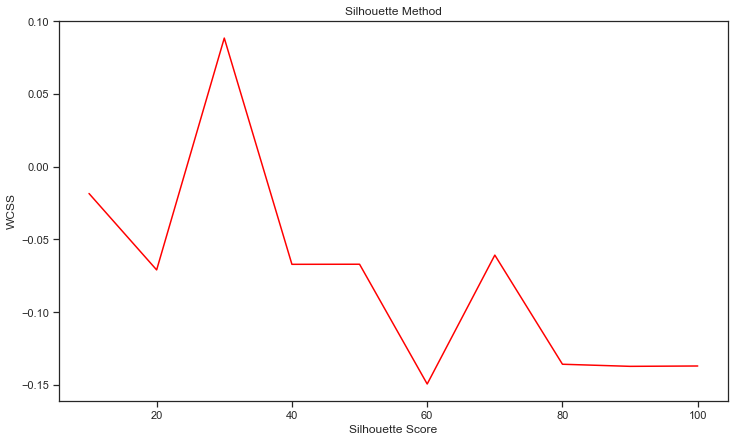

In [101]:
# Elbow Plot
plt.figure(figsize=(12,7))
plt.plot(range(10, 101, 10), wcss_grand['inbound_cv_ss_wcss'], color = 'magenta')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Silouette Plot
plt.figure(figsize=(12,7))
plt.plot(range(10, 101, 10), silhouette_scores, color = 'red')
plt.title('Silhouette Method')
plt.xlabel('Silhouette Score')
plt.ylabel('WCSS')
plt.show()


## Visualizing my Clusters with t-SNE

In [ ]:
# instantiate t-SNE
tsne = TSNE(n_components=2, random_state=1, n_jobs=-1)

# fit t-SNE
X_s_tsne = tsne.fit_transform(X_s)

# visualize high-dimensional data
plt.figure()
plt.scatter(X_s_tsne[:,0], X_s_tsne[:,1], s=20)
plt.title('2-D t-SNE representation of my Inbound data')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

## 2. LDA (Latent Dirichlet Allocation)
My second approach for the clustering is LDA topic modelling. It basically takes your data and splits it into topics. My goal is still to cluster, but with this method I hope to get more useful, distinct topics.

Useful articles:
* https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
* https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05

There are also newer, deep-learning based methods called LDA2Vec which could be interesting to explore as well.

# 3. Hierarchical Clustering

Height represents how much seperation there are between clusters. If not much distance between old centers and new centers, it signals that there is not much separation.

In [4]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Creating out linkage matrix
linkage_mat linkage(X, 'ward')

# Plotting our dendrogram
plt.figure(figsize =(20,20))
dendrogram(linkage_mat)
plt.show()

SyntaxError: invalid syntax (<ipython-input-4-225f98002726>, line 4)

# 4. DBSCAN
Density-based spatial clustering of applications with noise.

1. Choose a point at random
2. If that point is connected to greater than n points within d distance, it is a core sample. If not, it is classed as noise, and another point is chosen
3. Assign it, and all points within d distance as belonging to cluster x
4. Check all points just marked 0 if any are core cluseters, repeat step 3-4

For time constraint's sake, I decided not to use DBScan because they will achieve a clustering result similar to K-Means. I could have also use Gaussian Mixed Models or Heirarchical Clustering to achieve this clustering result.

# Fitting all with optimized hyperparamaters

In [ ]:
# K-Means Final


Storing all our results in a final dataframe:

# Comparing All our Clustering Methods

## With a Contingency Table

In [ ]:
# Do the clusterings tend to agree with one another?
# We'll make what's called a contingency table
pd.crosstab(cc_df2['cluster'], cc_df2['hcluster'])

We see the largest values here in the off-diagonal. And this is a good sign, because the cluster labels are arbitrary in any of the clusterings (i.e. KMeans 0 is HCluster's 1). Let's look at the percentages:

In [ ]:
pd.crosstab(cc_df2['cluster'], cc_df2['hcluster']) / len(cc_df2)

Even though the cluster labels are different, this actually looks pretty good because ~83 percent of the data is in the off-diagonal, meaning that the KMeans and the Hclust agreed on ~83% of the points being clustered.

The labels are arbitrary, in the event that they use opposite labelings then you woul look at the other diagonal.

We can also analyze, for a single clustering, why did the clusterer come to the groupings that it did? (e.g. What similarities and differences did it find in the data?)

## With the silhouette scores

## Finding and Visualizing Intent Differences Between Clusters

Sample the data, then for reproducibility set a random state.

In [250]:
# For 5 clusters
ten_clust = pd.DataFrame({'data': processed_X_train,'original': original, 'labels': labels[6]}).sort_values('labels',ignore_index = True)
six_clust = pd.DataFrame({'data': processed_X_train,'labels': labels[3]})

In [253]:
ten_clust.to_csv('ten_clust.csv') # Storing to CSV to view results
ten_clust[ten_clust['labels'] == 0]

,data,original,labels
0,"[yep, i, have, thought, app, site, fault, yikes]",@285455 Yep - I've had that too. I thought it ...,0
1,"[still, waiting, order, status, change, order,...",Still waiting for my order status to change fr...,0
2,"[using, #ios11, ipadair, 2, conclude, ruined, ...","After a while using #ios11 on my iPadAir2, I c...",0
3,"[1st, messages, deleted, pics, gone, wtf, get,...",1st all my messages deleted now all my pics ar...,0
4,"[hi, want, view, us, app, store, i, am, uk, on...",@AppleSupport Hi I want to view the US app sto...,0
...,...,...,...
15816,"[help, please, every, time, ️, type, letter, ️...",@AppleSupport Help please every time i️ type t...,0
15817,"[say, 7hrs, .., pretty, awful, ask, :(]",@AppleSupport I’d say about 7hrs.. which is pr...,0
15818,"[stop, ️, swearr, tooo, god, sound, bad, atm, ...",IF THIS DOES NOT STOP I️ SWEARR TOOO GOD @1158...,0
15819,"[man, ️, keep, popping, type, letter, comes, h...",Man why do this “ I️ “keep popping up when we...,0


In [252]:
ten_clust[ten_clust['labels'] == 1]

,data,original,labels
15821,"[11.1, 2, still, fixed, many, bug, issues, iph...",@AppleSupport 11.1.2 still hasn’t fixed many o...,1
15822,"[got, brand, new, iphone, 8, plus, stuck, reco...",I’ve got a brand new @115858 iPhone 8 Plus tha...,1
15823,"[iphone, 6s, battery, life, completely, crappe...",My iPhone 6S battery life has completely crapp...,1
15824,"[iphone, 8, plus, problem, speakers, sound, ev...",@AppleSupport iphone 8 plus I have a problem w...,1
15825,"[iphone, 5s, keeps, dying, 40, snapchat, app, ...",@AppleSupport iPhone 5S keeps dying on 40%+ wh...,1
...,...,...,...
22285,"[iphone, trippin, mane, cause, want, go, buy, ...","@115858 why my iphone trippin mane, it’s cause...",1
22286,"[tried, see, pic, iphone, x, showing, corner, ...",@AppleSupport I tried that but if you can see ...,1
22287,"[wanna, able, change, screen, gestures, iphone...",I wanna be able to change the screen gestures ...,1
22288,"[iphone, hangs, lot, ..., really, reason, ...,...",@AppleSupport My iPhone hangs a lot....I reall...,1


In [39]:
ten_clust[ten_clust['labels'] == 2]

NameError: name 'ten_clust' is not defined

In [78]:
# We give our estimators as a list of tuples: name:function.
estimators = [('embedding', EmbeddingTransformer()),
              ('model', KMeans())]

pipe = Pipeline(estimators, memory = cachedir)

params = [
    {'embedding': [EmbeddingTransformer()], 'model': [KMeans()],
    'embedding__model':['glove'],'model__n_cluster': [8]},
    {'embedding':[EmbeddingTransformer()], 'model': [LatentDirichletAllocation()],
    'embedding_model':['glove']}
]

grid = GridSearchCV(pipe, param_grid=params)

In [ ]:
fittedgrid = grid.fit(X_train, y_train)

In [ ]:
fittedgrid.best_estimator_

In [ ]:
fittedgrid.cv_results_['mean_test_score']